In [1]:
import os, sys, re, functools, itertools, collections, time, random, pickle, warnings, json
pkg_path = '/home/jupyter/code'
if pkg_path not in sys.path:
    sys.path.append(pkg_path)
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from utility import get_label_image, get_cor, get_cor_map, get_topk_indices, get_cor_map_4d, get_local_mean
from utility import get_prime_factors
from visualization import imshow, plot_image_label_overlay, make_video_ffmpeg, get_good_colors, plot_colortable
from models import UNet
from denoise import get_denoised_mat, model_denoise, SeparateNet
from segmentation import get_traces

use_gpu = True
if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load data

In [2]:
# data_folder = '../data'
data_folder = 'optosynth_test_mb_2'
mat = torch.from_numpy(np.load(f'{data_folder}/mat.npy')).float().to(device)
nframe, nrow, ncol = mat.shape
use_global_features = True
if use_global_features:
    features = torch.from_numpy(np.load(f'{data_folder}/features.npy')).float().to(device)
    num_global_features = features.shape[0]
else:
    features = None
    num_global_features = 0

# Noise2Self

In [ ]:
save_folder = '2d-noise2self_with_features_2segments'
use_existing_config = True
use_pretrained_model = True
use_importance_sampling = False
ndim = 2
out_channels =  [64, 64, 128] #[64, 64, 64] #[32, 32, 32]
frame_depth = 4
kernel_size = 3
last_out_channels = [100]
separate_net = False
batch_size = 10
batch_size_eval = 20
window_size_row = None # 96
window_size_col = None # 96

num_epochs = 2
num_iters = 1600
mask_prob = 0.05
loss_threshold = 0
loss_reg_fn = nn.MSELoss()
optimizer_fn_args = {'lr': 1e-3, 'weight_decay': 1e-2}  
lr_scheduler = {'lr_fn': lambda epoch, num_epochs, lr0, log_fold_change: lr0 * np.exp(-log_fold_change/max(num_epochs-1, 1)*epoch), 
                'lr_fn_args': {'lr0': optimizer_fn_args['lr'], 'num_epochs': num_epochs, 'log_fold_change': np.log(10)}}
optimizer_fn = torch.optim.AdamW
movie_start_idx = 100
movie_end_idx = 700

if separate_net:
    num_features = 32
    temporal_out_channels=[32, 32, 32, 1]
    num_conv_temporal = len(temporal_out_channels)
    assert temporal_out_channels[-1] == 1
    assert (2*frame_depth) % num_conv_temporal == 0

if use_existing_config and os.path.exists(f'{save_folder}/config.json'):
    with open(f'{save_folder}/config.json', 'r') as f:
        config = json.load(f)
        print('Use existing config.json:\n', json.dumps(config, indent=2))
        ndim = config['default_config']['model_config']['ndim']
        out_channels = config['default_config']['model_config']['out_channels']
        frame_depth = config['default_config']['model_config']['frame_depth']
        kernel_size = config['default_config']['model_config']['kernel_size']
        last_out_channels = config['default_config']['model_config']['last_out_channels']
        separate_net = config['default_config']['model_config']['separate_net']
        if separate_net:
            num_features = config['default_config']['model_config']['num_features']
            temporal_out_channels = config['default_config']['model_config']['temporal_out_channels']
            num_conv_temporal = len(temporal_out_channels)
else:
    config = {'default_config': {'model_config': 
                             {'ndim': ndim, 'out_channels': out_channels, 'frame_depth': frame_depth, 'kernel_size': kernel_size,
                              'last_out_channels': last_out_channels, 'separate_net': separate_net}}}
    if config['default_config']['model_config']['separate_net']:
        config['default_config']['model_config'].update({'num_features': num_features, 'temporal_out_channels': temporal_out_channels})

print_every = max(num_iters // 2, 1)
assert kernel_size%2==1
encoder_depth = len(out_channels)
padding = (kernel_size-1)//2
pool_kernel_size_row = get_prime_factors(nrow)[:encoder_depth]
pool_kernel_size_col = get_prime_factors(ncol)[:encoder_depth]
if window_size_row is not None and window_size_col is not None:
    assert window_size_row % np.product(pool_kernel_size_row) == 0
    assert window_size_col % np.product(pool_kernel_size_col) == 0

if ndim == 2:
    if separate_net:
        k = 2*frame_depth//num_conv_temporal + 1
        model = SeparateNet(in_channels=1, num_features=num_features, spatial_out_channels=out_channels,
                 num_conv=2, kernel_size=kernel_size, padding=padding, 
                 pool_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in range(encoder_depth)],  
                 transpose_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))],
                 transpose_stride=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                 last_out_channels=last_out_channels, 
                 use_adaptive_pooling=False, padding_mode='replicate', 
                 temporal_out_channels=temporal_out_channels, temporal_kernel_size=(k, 1, 1),
                 normalization='layer_norm', activation=nn.LeakyReLU(negative_slope=0.01, inplace=True)).to(device)
    else:
        in_channels = frame_depth*2 + 1 + num_global_features
        model = UNet(in_channels=in_channels, num_classes=1, out_channels=out_channels, num_conv=2, n_dim=2, 
                     kernel_size=kernel_size, 
                     padding=padding, 
                     pool_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in range(encoder_depth)], 
                     transpose_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                     transpose_stride=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                     last_out_channels=last_out_channels, 
                     use_adaptive_pooling=False, same_shape=True, padding_mode='replicate', normalization='layer_norm',
                     activation=nn.LeakyReLU(negative_slope=0.01, inplace=True)).to(device)
elif ndim == 3:
    assert frame_depth % encoder_depth == 0
    k = frame_depth//encoder_depth + 1
    model = UNet(in_channels=1, num_classes=1, out_channels=out_channels, num_conv=2, n_dim=3, 
             kernel_size=[kernel_size] + [(k, kernel_size, kernel_size)]*encoder_depth + [(1, kernel_size, kernel_size)]*encoder_depth, 
                 padding=[padding] + [(0, padding, padding)]*encoder_depth*2,
                 pool_kernel_size=[(1, pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in range(encoder_depth)], 
                 transpose_kernel_size=[(1, pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                 transpose_stride=[(1, pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                 last_out_channels=last_out_channels,
                 use_adaptive_pooling=True, same_shape=False, padding_mode='zeros', normalization='layer_norm', 
                 activation=nn.LeakyReLU(negative_slope=0.01, inplace=True)).to(device)
cnt = 0
for n, p in model.named_parameters():
    cnt += p.numel()
print(f'Total number of model parameters = {cnt}')
config['default_config']['model_config'].update({'num_total_params': cnt})

if not os.path.exists(save_folder):
    print(f'Creating folder {save_folder}')
    os.makedirs(save_folder)

loss_history = []
if use_pretrained_model and os.path.exists(f'{save_folder}/loss__denoise.npy'):
    loss_history = np.load(f'{save_folder}/loss__denoise.npy').tolist()
    print(f'loading model state {save_folder}/model_step{len(loss_history)}.pt')
    model.load_state_dict(torch.load(f'{save_folder}/model_step{len(loss_history)}.pt'))
    plt.figure(figsize=(15, 9))
    plt.plot(loss_history, 'o-', markersize=3)
    plt.ylabel('loss')
    plt.xlabel(f'iteration')
    plt.title(f'loss_history[{len(loss_history)}] = ({loss_history[-1]:.3e})')
    plt.show()
    
if use_importance_sampling:
    frame_mean = mat.mean((1, 2))
    frame_weight = frame_mean - frame_mean.min()
    frame_weight = frame_weight + frame_weight.median()
    frame_weight /= frame_weight.sum()
    frame_weight = frame_weight.cpu().numpy()
else:
    frame_weight = None

Epoch 1 set learning rate to be 1.00e-03
i=1, loss=0.6489455699920654
i=800, loss=0.6674015522003174
i=1600, loss=0.6596354842185974
Epoch 1 time: 542.2114150524139


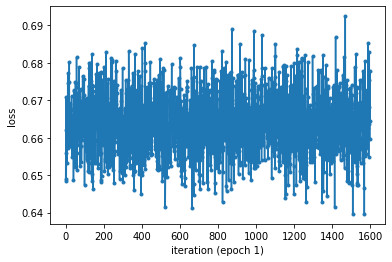

Epoch 2 set learning rate to be 9.43e-04
i=1, loss=0.6590694785118103
i=800, loss=0.6734660863876343
i=1600, loss=0.6763181090354919
Epoch 2 time: 541.857522726059


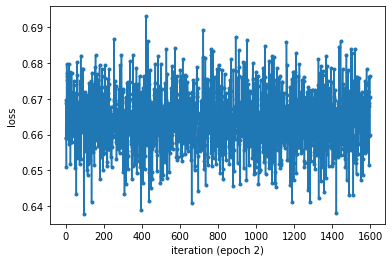

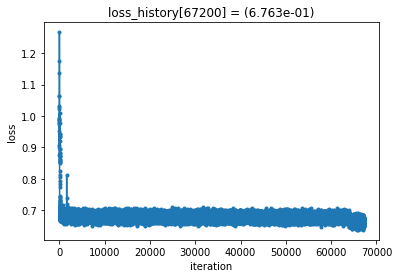

Total time spent: 1106.9172959327698


In [17]:
train_interval = [0, mat.shape[0]]
train_index = range(*train_interval)
start_time = time.time()
denoised_mat, model = get_denoised_mat(mat[train_index], model=model, ndim=ndim, out_channels=out_channels, 
                                       num_epochs=num_epochs, num_iters=num_iters, 
                                       print_every=print_every, batch_size=batch_size, mask_prob=mask_prob, 
                                       frame_depth=frame_depth, frame_weight=frame_weight, 
                                       movie_start_idx=movie_start_idx, movie_end_idx=movie_end_idx, 
                                       save_folder=save_folder, 
                                       save_intermediate_results=False, normalize=True, 
                                       last_out_channels=last_out_channels, 
                                       loss_reg_fn=loss_reg_fn, loss_history=loss_history, loss_threshold=loss_threshold, 
                                       optimizer_fn=optimizer_fn, optimizer_fn_args=optimizer_fn_args, lr_scheduler=lr_scheduler,
                                       batch_size_eval=batch_size_eval, features=features,
                                       window_size_row=window_size_row, window_size_col=window_size_col, weight=None,
                                       verbose=True, return_model=True, device=device)
end_time = time.time()

num_episodes = len([k for k in config.keys() if re.search('^episode', k)])
config[f'episode{num_episodes}'] = {'train_settings': 
                                   {'num_epochs': num_epochs, 'num_iters': num_iters, 'batch_size': batch_size, 
                                    'batch_size_eval': batch_size_eval, 'mask_prob': mask_prob,
                                    'use_importance_sampling': use_importance_sampling, 'time_spent': end_time-start_time,
                                    'optimizer_fn_args': optimizer_fn_args, 'train_interval': train_interval
                                   }}
if lr_scheduler is not None:
    config[f'episode{num_episodes}']['train_settings']['lr_scheduler'] = (
        [lr_scheduler['lr_fn'](epoch, **lr_scheduler['lr_fn_args']) for epoch in range(num_epochs)])
with open(f'{save_folder}/config.json', 'w') as f:
    json.dump(config, f, indent=2)

In [18]:
if mat[train_index].shape[0] < mat.shape[0]:
    start_time = time.time()
    denoised_mat = model_denoise(mat, model, ndim=ndim, frame_depth=frame_depth, features=features, batch_size=batch_size_eval, 
                                 normalize=True)
    end_time = time.time()
    np.save(f'{save_folder}/denoised_movie_frame0to{mat.shape[0]}_step{len(loss_history)}.npy', denoised_mat.cpu().numpy())
    print(end_time - start_time)

In [25]:
target = np.load(f'{data_folder}/clean.npy') - np.load(f'{data_folder}/trend.npy')

In [33]:
from utility import scale_and_shift
make_video_ffmpeg(np.concatenate([scale_and_shift(m, scale=255) for m in [denoised_mat.cpu(), target, denoised_mat.cpu()-target]], axis=1), 
                      f'{save_folder}/denoised_movie_frame0to{mat.shape[0]}_step{len(loss_history)}.avi')